# Multi-label text classification using BERT

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_data = pd.read_csv('./courses.csv', encoding='latin-1')

# Combine title and description to increase power
df_data['combined'] = df_data['title'] + '. ' + df_data['description']
df_data.drop(columns=['link', 'title', 'description'], axis=1, inplace=True)
df_data.fillna(0, inplace=True)
df_data[df_data.columns[:-1]] = df_data[df_data.columns[:-1]].astype(int)
df_data.head()

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,G2,G3,G4,G5,G6,G7,G8,G9,G10,combined
0,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,How to transform the energy system and reduce ...
1,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,"Renewable Energy Sources Cut Carbon Emissions,..."
2,1,1,1,0,0,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,Renewable Energy Sources and Climate Change Mi...
3,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,Climate Change. The Ecological Footprint frame...
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"Climate Change. Across the globe, TNC is tackl..."


In [3]:
from sklearn.model_selection import train_test_split

# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)

# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [4]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (70, 31), Test: (15, 31), Valid: (15, 31)


## Model Definition

In [5]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW
import tqdm.notebook as tq
from collections import defaultdict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [8]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.texts = list(df['combined'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'text': text
        }

In [10]:
target_list = list(df_data.columns)
target_list = target_list[:-1]
print(target_list)

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']


In [11]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [12]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101,  1996,  5762,  8906,  1998, 10502,  6111,  2005, 12433,  1012,
          1996,  5020,  6695,  3222,  1006,  1041, 10085,  1007,  2003,  3625,
          2005, 14972,  1996,  2176,  3424,  1011,  9147, 16692,  2015,  1999,
          4291,  4290,  1010,  8419,  1996,  3348,  9147, 16692,  1010, 11980,
          9147, 16692,  1010,  2155,  3570,  9147, 16692,  1998,  1996,  2679,
          9147, 16692,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [13]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [14]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(target_list))

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [15]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [16]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

c:\Users\JK\anaconda3\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,30)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [18]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [19]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "MLTC_model_state.bin")
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.7085, val_loss=0.6830 train_acc=0.5205, val_acc=0.5689
Epoch 2/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6911, val_loss=0.6797 train_acc=0.5500, val_acc=0.5978
Epoch 3/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6709, val_loss=0.6711 train_acc=0.5876, val_acc=0.6222
Epoch 4/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6677, val_loss=0.6544 train_acc=0.6062, val_acc=0.6622
Epoch 5/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6631, val_loss=0.6461 train_acc=0.6205, val_acc=0.6533
Epoch 6/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6457, val_loss=0.6378 train_acc=0.6352, val_acc=0.6444
Epoch 7/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6501, val_loss=0.6296 train_acc=0.6529, val_acc=0.6622
Epoch 8/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6355, val_loss=0.6221 train_acc=0.6676, val_acc=0.6822
Epoch 9/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6177, val_loss=0.6149 train_acc=0.6805, val_acc=0.7156
Epoch 10/10


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss=0.6189, val_loss=0.6086 train_acc=0.7033, val_acc=0.7378


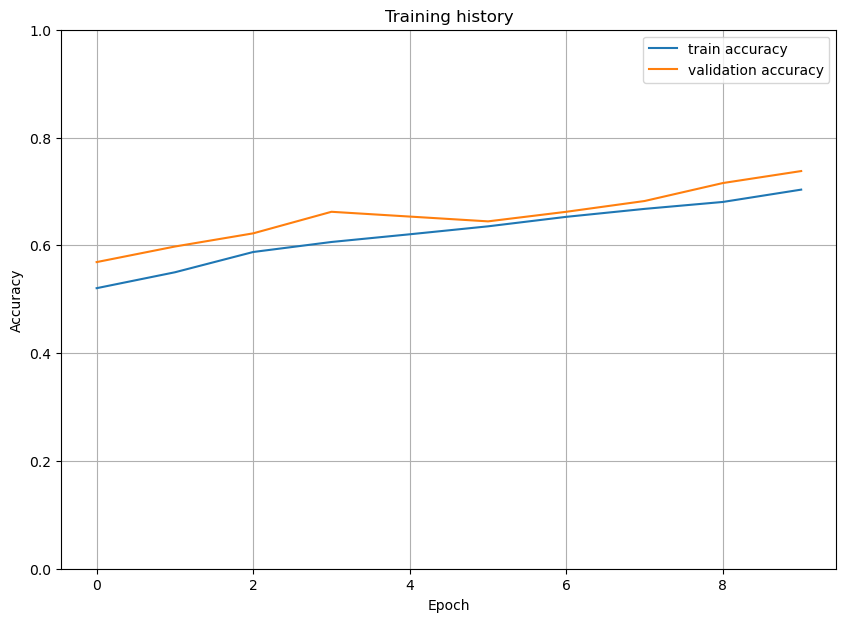

In [20]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

## Model Evaluation

In [21]:
from sklearn.metrics import classification_report

In [22]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load("MLTC_model_state.bin"))
model = model.to(device)
model = model.eval()

In [23]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [24]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.7422222222222222

In [25]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        text = data["text"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        texts.extend(text)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return texts, predictions, prediction_probs, target_values

In [26]:
texts, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [27]:
# sanity check
predictions

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

In [28]:
prediction_probs

tensor([[0.4830, 0.3501, 0.3958, 0.3791, 0.3217, 0.4541, 0.2887, 0.3744, 0.3448,
         0.4660, 0.5147, 0.4104, 0.4973, 0.4370, 0.5569, 0.4153, 0.5902, 0.6517,
         0.3559, 0.4492, 0.3903, 0.3906, 0.4184, 0.5075, 0.4082, 0.4209, 0.3611,
         0.3632, 0.3946, 0.5096],
        [0.4987, 0.3651, 0.3761, 0.3698, 0.3364, 0.5002, 0.2707, 0.3879, 0.3481,
         0.4472, 0.5170, 0.3721, 0.4550, 0.4873, 0.5172, 0.4195, 0.5704, 0.6029,
         0.3645, 0.4432, 0.3772, 0.3753, 0.3898, 0.5220, 0.4246, 0.4006, 0.3583,
         0.3738, 0.3754, 0.4865],
        [0.4876, 0.4017, 0.3845, 0.3586, 0.3529, 0.5291, 0.2617, 0.3604, 0.3958,
         0.4672, 0.5281, 0.3918, 0.4704, 0.4840, 0.5327, 0.4454, 0.5725, 0.5985,
         0.3466, 0.4178, 0.4062, 0.3943, 0.3987, 0.4697, 0.4224, 0.3969, 0.3386,
         0.3552, 0.3958, 0.4949],
        [0.4670, 0.4663, 0.3867, 0.3531, 0.3100, 0.5770, 0.2898, 0.3161, 0.4280,
         0.4187, 0.5871, 0.3258, 0.4194, 0.5361, 0.4757, 0.3646, 0.5293, 0.5371,
       

In [29]:
print(f"courses:{len(texts)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

courses:15 
predictions:torch.Size([15, 30]) 
prediction_probs:torch.Size([15, 30]) 
target_values:torch.Size([15, 30])


In [30]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

          E1       0.50      0.33      0.40         3
          E2       0.00      0.00      0.00         2
          E3       0.00      0.00      0.00         3
          E4       0.00      0.00      0.00         3
          E5       0.00      0.00      0.00         3
          E6       0.31      1.00      0.47         4
          E7       0.00      0.00      0.00         2
          E8       0.00      0.00      0.00         2
          E9       0.00      0.00      0.00         4
         E10       1.00      0.17      0.29         6
          S1       0.46      1.00      0.63         6
          S2       0.00      0.00      0.00         1
          S3       0.00      0.00      0.00         6
          S4       0.56      0.50      0.53        10
          S5       0.78      0.70      0.74        10
          S6       0.00      0.00      0.00         6
          S7       0.69      1.00      0.82         9
          S8       0.46    

c:\Users\JK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predicting on new data

In [31]:
# raw text
raw_title = "SDGAcademyX: Measuring Sustainable Development"
raw_description = "The United Nations Sustainable Development Goals are an ambitious global agenda for prosperity, people, and planet. But how do we know if we are on track to achieve the SDGs? Which Goals should different stakeholders prioritize? And what kind of data do we need to ensure that no one is left behind?"
raw_text = raw_title + ". " + raw_description

In [32]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

In [33]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
# add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
print(output)
# thresholding at 0.5
output = output.flatten().round()
print(output)

tensor([[0.5124, 0.4283, 0.3844, 0.3935, 0.3504, 0.5535, 0.3505, 0.3315, 0.3985,
         0.4905, 0.4654, 0.3789, 0.4184, 0.5431, 0.4515, 0.3855, 0.5091, 0.4849,
         0.3749, 0.3889, 0.3878, 0.3639, 0.3852, 0.4584, 0.3496, 0.4477, 0.4265,
         0.4500, 0.3410, 0.4663]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [34]:
# Identified the subtopics of the course
print(f"Course: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

Course: SDGAcademyX: Measuring Sustainable Development. The United Nations Sustainable Development Goals are an ambitious global agenda for prosperity, people, and planet. But how do we know if we are on track to achieve the SDGs? Which Goals should different stakeholders prioritize? And what kind of data do we need to ensure that no one is left behind?
Label: E1
Label: E6
Label: S4
Label: S7
